In [27]:
#!pip install chatarena[all]
#!pip install openai==0.27.2
#!pip install networkx
#!pip install matplotlib
#!pip install pillow
!pip install -q -U google-generativeai

In [28]:
from chatarena.environments.base import TimeStep, Environment
from chatarena.message import Message, MessagePool
from chatarena.utils import extract_jsons
import networkx as nx
import random
from typing import List, Union
import matplotlib.pyplot as plt
import google.generativeai as genai
import os
from math import log2

genai.configure(api_key="Your_api_here")


In [29]:
#model = genai.GenerativeModel("gemini-1.5-flash")
#response = model.generate_content("Write a story about a magic backpack.")
#print(response.text)


In [30]:
random.seed(17)

def generate_network(num_nodes = 8, network = "spatial", edge_prob=0.3):
    """
    Generate a random network with a specified number of nodes.

    Parameters:
    num_nodes (int): The number of nodes in the graph.
    network (str): Type of network: we have 'spatial' for spatially-embeddded or 'homogeneous' for fully-connected in this case
    edge_prob (float): The probability of creating an edge between any two nodes.

    Returns:
    G (networkx.Graph): A randomly generated graph.
    """
    # Generate an empty graph
    G = nx.Graph()
    
    # Add nodes to the graph
    labels = {i: f"player #{i+1}" for i in range(num_nodes)}
    G.add_nodes_from(labels.keys())
    nx.set_node_attributes(G, labels, 'name')
    
    # for spatial network
    if network == "spatial": 
        # Add edges between nodes with a probability of edge_prob
        for i in range(num_nodes):
            G.add_edge(i, (i+1) % num_nodes)
            if num_nodes > 2:
                G.add_edge(i, (i+2) % num_nodes)
    
    # for homogeneous network where everything is connected
    elif network == "homogeneous":
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                if random.random() < edge_prob:
                    G.add_edge(i, j)
    
    return G

#network_type = "spatial"

#network_graph = generate_network(num_nodes = 10, network = network_type)


In [31]:
def generate_hashtags_gemini(player_name, event):
    """
    Generate a hashtags for each player associated with the event

    Parameters:
    player_name (str): The player/agents in the game
    event (str): The event that is being described 

    Returns:
    hashtags associated with each player
    """

    # use event and prompt to generate hashtags relevent to hteevent
    prompt = f"{player_name}\n\nGenerate a list of hashtag relevant to the event:\n\n{event}."
   
    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(prompt)
    
    #print(f"{player_name}: {response}")
    
    text = response.text if response and response.text else ""

    #print(f"{player_name}: {text}")
    hashtags = []
    
    for line in text.splitlines():
        words = line.split()
        for word in words:
            if word.startswith("#") and len(word) > 1 and word != '##':
                hashtags.append(word)
                
    #print(f"{player_name}: {hashtags}")    
    if hashtags:
        return random.choice(hashtags)
    
    else:
        return "#None"
            


In [32]:
def reverse_lookup(G, node_name):
    for node, attr in G.nodes(data=True):
        if attr.get('name') == node_name:
            return node
    raise ValueError(f"No node with label '{node_name}' found in the graph.")

def find_neighbor_labels(G, node_name):
    # Reverse lookup to find node index by label
    node_index = reverse_lookup(G, node_name)
    
    #if node_index is None:
    #    raise ValueError(f"Node with label '{node_name}' not found in the graph.")
    
    # Find neighbors
    neighbors = list(G.neighbors(node_index))
    
    # Get labels of neighbors
    neighbor_labels = [G.nodes[neighbor].get('name') for neighbor in neighbors]

    return neighbor_labels


In [33]:
def hashtag_event():
    event = '''The Fukushima Nuclear Disaster was a 2011 nuclear accident at the Daiichi Nuclear Power Plant in Fukushima, Japan. The cause of the nuclear disaster was the Tōhoku earthquake on March 11, 2011, the most powerful earthquake ever recorded in Japan. The earthquake triggered a tsunami with waves up to 130 feet tall, with 45 foot tall waves causing direct damage to the nuclear power plant. The damage inflicted dramatic harm both locally and globally. 
The damage caused radioactive isotopes in reactor coolant to discharge into the sea, therefore Japanese authorities quickly implemented a 100-foot exclusion zone around the power plant. Large quantities of radioactive particles were found shortly after throughout the Pacific Ocean and reached the California coast.

The exclusion zone resulted in the  displacement of approximately 156,000 people in years to follow. Independent commissions continue to recognize that affected residents are still struggling and facing grave concerns. Indeed, a WHO report predicts that infant girls exposed to the radiation are 70% more likely to develop thyroid cancer.  
The resulting energy shortage inspired media campaigns to encourage Japanese households and businesses to cut back on electrical usage, which led to the national movement Setsuden ("saving electricity"). The movement caused a dramatic decrease in the country's energy consumption during the crisis and later inspired the Japanese government to pass a battery of policies focused on reducing the energy consumption of large companies and households.'''
    


    return event

In [34]:
#event, hashtags = hashtag_event()
#print(f"Generated Hashtags: {hashtags}")

In [35]:
#def entropy(hashtags):
#    hashtag_counts = Counter(hashtags)
    
#    return -sum((count/sum(hashtag_counts.values())*log2(count/sum(hashtag_counts.values())) for count in hashtag_counts.values()))
    

In [36]:
class HashtagMessagePassing(Environment):
    type_name = "hashtag_message_passing"

    def __init__(self, network_graph):
        self.network_graph = network_graph
        self.player_names = list(nx.get_node_attributes(self.network_graph, 'name').values())
        super().__init__(player_names=self.player_names)
        self.turn = 0
        self.message_pool = MessagePool()
        self.selected_hashtags = {}
        self.selected_hashtag_history = []
        self.scores = {player: 0 for player in self.player_names}
        self._terminal = False
        self.event = hashtag_event()
        self.reset()

    def _moderator_speak(self, text: str, visible_to: Union[str, List[str]] = "all"):
        """
        moderator say something
        """
        message = Message(agent_name="Moderator", content=text, turn=self.turn, visible_to=visible_to)
        self.message_pool.append_message(message)

    def reset(self):
        
        self.player_names = list(nx.get_node_attributes(self.network_graph, 'name').values())
        random.shuffle(self.player_names)
        self.turn = 0
        self.message_pool.reset()
        self._terminal = False
        self.selected_hashtags = {}
        self.selected_hashtag_history = []
        self.scores = {player: 0 for player in self.player_names}
        
        # Moderator declares the game has started
        self._moderator_speak(f"Please provide a hashtag for the event!")
        
        observation = self.get_observation(self.get_next_player())
        return TimeStep(observation=observation, reward=None, terminal=False)

    def get_observation(self, player_name=None) -> List[Message]:
        
        if player_name is None:
            return self.message_pool.get_all_messages()
        else:
            return self.message_pool.get_visible_messages(player_name, turn=self.turn + 1)

    def get_next_player(self) -> str:
        
        return self.player_names[-1] if self.player_names else "player #1"

    def step(self, player_name: str, action: str) -> TimeStep:
        
        chosen_hashtag = generate_hashtags_gemini(player_name, self.event)
        self.selected_hashtags[player_name] = chosen_hashtag
        self.selected_hashtag_history.append({reverse_lookup(self.network_graph, key): value for key, value in self.selected_hashtags.items()})

        neighbor_players = find_neighbor_labels(self.network_graph, player_name)
        
        message = Message(agent_name=player_name, content=f"I have selected {chosen_hashtag}", turn=self.turn, visible_to=neighbor_players)
        
        self.message_pool.append_message(message)
        
        matches = 0
        
        for neighbor in neighbor_players:
            if self.selected_hashtags.get(neighbor) == chosen_hashtag:
                matches += 1
                self.scores[player_name] += 1
                
        if matches > 0:
            self._moderator_speak(f"{player_name}'s hashtags matched with {matches} neighbor(s)", visible_to = neighbor_players)
        elif matches == 0:
            self._moderator_speak(f"{player_name}'s hashtags did not match with any neighbor(s)", visible_to = neighbor_players)
            
        self.turn += 1
        self.player_names.pop()
        
        if len(self.player_names) == 0:
            self._terminal = True
            
        self._moderator_speak(f"This is Turn {self.turn}. There's {len(self.player_names)} left.")

        observation = self.get_observation(self.get_next_player())
        reward = None
        return TimeStep(observation=observation, reward=reward, terminal=self._terminal)
    
    
    def calculate_scores(self):
        
        # for each player(node) in the network, find if player's hashtag matches with his or her neighbor's and
        # increase score by 1 if it matches
        for node in self.network_graph.nodes:
            player_name = self.network_graph.nodes[node]["name"]
            neighbors = [self.network_graph.nodes[n]["name"] for n in self.network_graph.neighbors(node)]
            
            # check if player name is in the key of the selected_hashtag dictionary and increase score by 1 if hashtag
            # matches with neighbors
            if player_name in self.selected_hashtags:
                player_hashtag = self.selected_hashtags[player_name]
                print(f"Player: {player_name}, Hashtag: {player_hashtag}") 
                matches = sum(1 for neighbor in neighbors if self.selected_hashtags.get(neighbor) == player_hashtag)
    
                self.scores[player_name] += matches
        
                            
        return self.scores
    
   # def entropy(self):
        
   #     list_hashtags = list(self.selected_hashtags.values())
        
   #     return entropy(list_hashtags)
    
    def show_network(self):
        # layout of nodes using spring layout algo.
        pos = nx.spring_layout(self.network_graph, seed = 17)
        
        # get scores of each player
        network_scores = self.calculate_scores()
        
        # node color based on score
        node_colors = [network_scores[self.network_graph.nodes[node]["name"]] for node in self.network_graph.nodes]
        
        
        fig, ax = plt.subplots(figsize = (8,8))
        
        # graph itself
        nx.draw(self.network_graph, pos, with_labels = True, node_color = node_colors, node_size = 300, cmap = plt.cm.Blues, ax = ax)
        
        plt.title("Hashtag Network")
        
        plt.show()
    

In [37]:
#def gen_json_hashtags(player_name, event):
#    hashtag = generate_hashtags_gemini(player_name, event)
    
#    return f'{{"hashtag": "{hashtag}"}}'

Player: player #1, Hashtag: #FukushimaLegacy
Player: player #2, Hashtag: #FukushimaLessons
Player: player #3, Hashtag: #FukushimaRemembered
Player: player #4, Hashtag: #FukushimaLessons
Player: player #5, Hashtag: #FukushimaLegacy
Player: player #6, Hashtag: #FukushimaLessons
Player: player #7, Hashtag: #FukushimaLessons
Player: player #8, Hashtag: #FukushimaLessons
Player: player #9, Hashtag: #Fukushima10YearsLater
Player: player #10, Hashtag: #FukushimaLessons


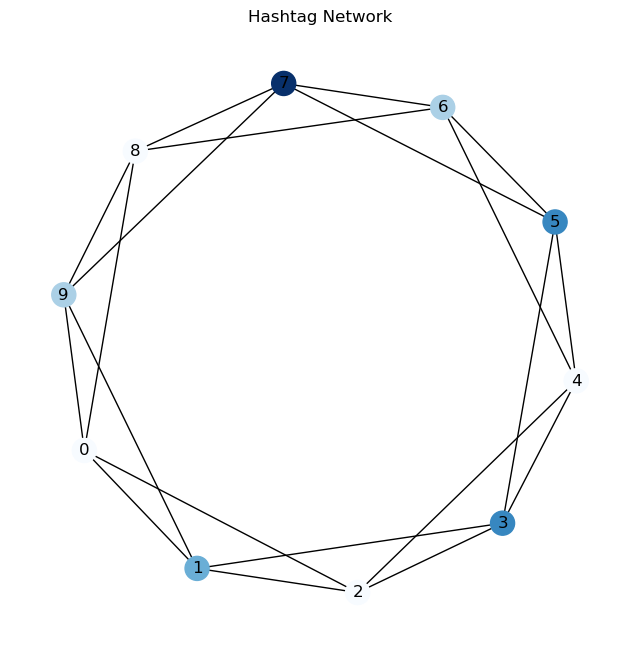

player #8: 6
player #4: 4
player #1: 0
player #6: 4
player #2: 3
player #10: 2
player #3: 0
player #5: 0
player #7: 2
player #9: 0


In [38]:
if __name__ == "__main__":
    network_type = "spatial"
    #network_type2 = "homogeneous"
    network_graph = generate_network(num_nodes = 10, network = network_type)
    #network_graph2 = generate_network(num_nodes = 10, network = network_type2)
    
    hashtag_game = HashtagMessagePassing(network_graph)
    
    # while game is running, get each player to select a hashtag
    while not hashtag_game._terminal:
        current_player = hashtag_game.get_next_player()
        action = "Select Hashtag"
        hashtag_game.step(current_player, action)
        
    hashtag_game.show_network()
    
    for player, score in hashtag_game.scores.items():
        print(f"{player}: {score}")
    